<strong><center>Conjugate Gradient Least Squares Algorithm</center></strong>  
    
We consider the following problems:

1. $$\min_{u} \| A u - b \|_{2}^{2} $$

2. $$\min_{u} \| A u - b \|_{2}^{2} + \alpha^{2} \| L x \|^{2}_{2} \quad(\mbox{Regularised CGLS})$$ 


* A \& L: Linear Operators 
* g: Degraded Data
* A = matrix $\Rightarrow$ Solve the linear system A u = b
* A = Radon Transform ( System Matrix for Tomography reconstruction )   
  g = Sinogram Data ( AcquisitionData )

<strong><center>Au = b using CGLS (Linear System)</center></strong>

In [1]:
import numpy as np
from ccpi.optimisation.algorithms import CGLS
from ccpi.optimisation.operators import LinearOperatorMatrix
from ccpi.framework import VectorGeometry

# Dimension Problem
m, n = 200, 300

np.random.seed(10)

# Create numpy matrix Amat and data bmat
Amat = np.asarray( np.random.randn(m, n), dtype = np.float32)
bmat = np.asarray( np.random.randn(m), dtype=np.float32)

# Geometries for Data and Solution
vgb = VectorGeometry(m)
vgx = VectorGeometry(n)

# Create Linear Operator A and data b
b = vgb.allocate(0, dtype=np.float32)
b.fill(bmat)
A = LinearOperatorMatrix(Amat)

# Allocate solution
x_init = vgx.allocate()

# Setup and run CGLS
cgls = CGLS(x_init = x_init, operator = A, data = b)
cgls.max_iteration = 2000
cgls.update_objective_interval = 200
cgls.run(2000, verbose = True)

CGLS set_up called from creator
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       2000         0.000          1.99444e+02
       55       2000         0.000          5.19532e-10
Tolerance is reached: 1e-06


<strong><center>Compare solution with CVXPY</center></strong>
    
* CVXPY is a Python-embedded modeling language for convex optimization problems. 
* A minimisation problem is expressed in a mathematical fashion.
* We use it for validation purposes for small/medium scale problems.

In [2]:
from cvxpy import *

# Compare with CVX
# Need numpy expressions 
x = Variable(n)
obj = Minimize(sum_squares(A.A*x - b.as_array()))
prob = Problem(obj)

# choose solver
if 'MOSEK' in installed_solvers():
    solver = MOSEK
else:
    solver = SCS 

result = prob.solve(solver = MOSEK)

diff_sol = x.value - cgls.get_output().as_array()
 
print('Error |CVX - CGLS| = {}'.format(np.sum(np.abs(diff_sol))))
print('CVX objective = {}'.format(obj.value))
print('CGLS objective = {}'.format(cgls.objective[-1]))

Error |CVX - CGLS| = 5.980766514216959e-05
CVX objective = 3.5117746297645086e-13
CGLS objective = 5.19532472598172e-10


<strong><center>CGLS \& Regularised CGLS (Tomography Example)</center></strong>

* A = Radon transform 
* b = Sinogram data with Gaussian/Poisson Noise
* Simple CGLS $\Rightarrow$ Ill-posed problem
* Add regularisation term $\Rightarrow$ Well-posed problem

In [3]:
import tomophantom
from tomophantom import TomoP2D

from ccpi.framework import ImageGeometry, AcquisitionGeometry, \
                           ImageData, AcquisitionData
import os
import matplotlib.pyplot as plt  

* Here we use the tomophantom package https://github.com/dkazanc/TomoPhantom.
* TomoPhantom is a toolbox written in C language to generate customisable 2D-4D phantoms.
* TomoPhantom is best-suited for testing various tomographic image reconstruction methods. 
* Example: 
    1. Classical Shepp-Logan (piecewise constant)
    2. Modified Shepp-Logan (piecewise smooth)

In [4]:
tomo_data = open("/Users/evangelos/Downloads/TomoPhantom/PhantomLibrary/models/Phantom2DLibrary.dat")
tomo_txt = tomo_data.read()
print(tomo_txt)

# 2D and 2D+t phantoms library, please use the following notations to define 2D geometrical objects:
# gaussian, parabola, ellipse, parabola1, cone, rectangle
# syntax for objects decription -- Object : object type (see names above), C0, x0, y0, a, b, angle
#----------Static (2D) Phantoms [no. 01-99]---------
#----------------------------------------------------
# Classical Shepp-Logan phantom (10 ellipses)
Model : 01;
Components : 10;
TimeSteps : 1;
Object : ellipse 1.0 0.0 0.0 0.69 0.92 0.0;
Object : ellipse -0.8 0.0184 0.0 0.6624 0.874 0.0;
Object : ellipse -0.2 0.0 0.22 0.11 0.31 18.0;
Object : ellipse -0.2 0.0 -0.22 0.16 0.41 -18.0;
Object : ellipse 0.1 -0.35 0.0 0.21 0.25 0.0;
Object : ellipse 0.1 -0.1 0.0 0.046 0.046 0.0;
Object : ellipse 0.1 0.1 0.0 0.046 0.046 0.0;
Object : ellipse 0.1 0.605 -0.08 0.046 0.023 0.0;
Object : ellipse 0.1 0.605 0.0 0.023 0.023 0.0;
Object : ellipse 0.1 0.605 0.06 0.023 0.046 0.0;
#----------------------------------------------------
# Piecewise-Sm

In [5]:
# Load  Shepp-Logan phantom 
model = 1 # select a model number from the library
N = 64 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")
phantom_2D = TomoP2D.Model(model, N, path_library2D)

In [6]:
# Define ImageGeometry for the Shepp-Logan phantom
ig1 = ImageGeometry(voxel_num_x = N, voxel_num_y = N)
data1 = ImageData(phantom_2D)

# Specify detectors and angles for the sinogram space
detectors =  N
angles = np.linspace(0, np.pi, 100, dtype=np.float32)

# Define AcquisitionGeometry
ag1 = AcquisitionGeometry('parallel','2D', angles, detectors)

# Select CPU/GPU device
device = input('Available device: GPU==1 / CPU==0 ')

if device =='1':
    dev = 'gpu'
else:
    dev = 'cpu'

Available device: GPU==1 / CPU==0 0


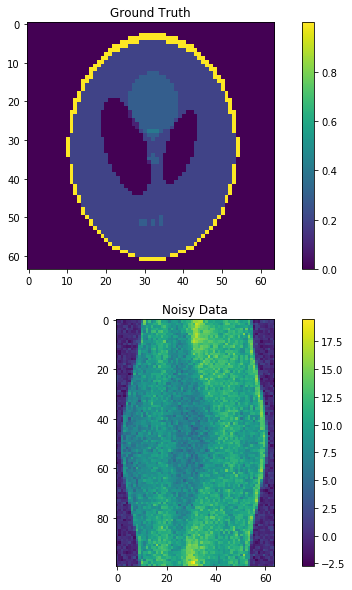

CGLS set_up called from creator
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         20         0.000          5.07163e+05
        5         20         0.008          5.16215e+04
       10         20         0.008          4.75637e+03
       15         20         0.008          3.29224e+03
       20         20         0.008          2.87335e+03


In [7]:
from ccpi.astra.operators import AstraProjectorSimple 

# Define Radon Transform operator by wrapping Astra toolbox
Aop = AstraProjectorSimple(ig1, ag1, dev)    

# Create sinogram
sin = Aop.direct(data1)

# Add noise on the sinogram, e.g. Gaussian noise
np.random.seed(10)
noisy_data = AcquisitionData( sin.as_array() + np.random.normal(0,1,ag1.shape))

# Show Ground Truth and Noisy Data
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(data1.as_array())
plt.title('Ground Truth')
plt.colorbar()
plt.subplot(2,1,2)
plt.imshow(noisy_data.as_array())
plt.title('Noisy Data')
plt.colorbar()
plt.show()

# Setup and run the simple CGLS algorithm  
x1 = ig1.allocate()  

cgls1 = CGLS(x_init = x1, operator = Aop, data = noisy_data)
cgls1.max_iteration = 20
cgls1.update_objective_interval = 5
cgls1.run(20, verbose = True)

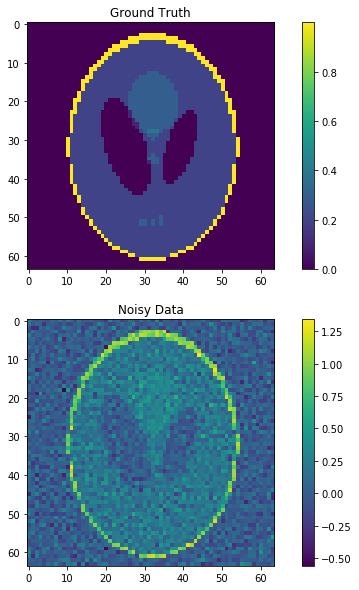

In [8]:
# Show Ground Truth and Noisy Data
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(data1.as_array())
plt.title('Ground Truth')
plt.colorbar()
plt.subplot(2,1,2)
plt.imshow(cgls1.get_output().as_array())
plt.title('Noisy Data')
plt.colorbar()
plt.show()

<strong><center>Regularised CGLS (Tomography Example)</center></strong>

$$\min_{u} \| A u - b \|_{2}^{2} +  \alpha^2\| L x \|^{2}_{2} \quad(\mbox{Regularised CGLS})$$ 

* L = Linear Operator  
    1. Identity Operator
    2. Gradient Operator
    
In order to use the CGLS algorithm for the above problem, we need to rewrite as 

$$\min_{u} \| \tilde A u - \tilde b \|_{2}^{2} $$

Hence, we define:

$$ \tilde A = 
\begin{bmatrix} 
A \\
\alpha L 
\end{bmatrix},\quad \tilde b = 
\begin{bmatrix} 
b \\
0 
\end{bmatrix}$$
    

In [9]:
from ccpi.optimisation.operators import BlockOperator, Gradient, Identity
from ccpi.framework import BlockDataContainer

# Define L operator
L1 = Identity(ig1)
L2 = Gradient(ig1)

alpha1 = 10
alpha2 = 5

# Define \tilde A
block_Aop_1 = BlockOperator( Aop, alpha1 * L1, shape=(2,1))
block_Aop_2 = BlockOperator( Aop, alpha2 * L2, shape=(2,1))

# Define \tilde b
block_data1 = BlockDataContainer(noisy_data, L1.range_geometry().allocate())
block_data2 = BlockDataContainer(noisy_data, L2.range_geometry().allocate())

# Setup and run the regularised CGLS algorithm  with L = Identity
x2 = ig1.allocate() 
cgls2 = CGLS(x_init = x2, operator = block_Aop_1, data = block_data1)
cgls2.max_iteration = 200
cgls2.update_objective_interval = 25
cgls2.run(200, verbose = True)


# Setup and run the regularised CGLS algorithm  with L = Gradient
x3 = ig1.allocate()    
cgls3 = CGLS(x_init = x3, operator = block_Aop_2, data = block_data2)
cgls3.max_iteration = 200
cgls3.update_objective_interval = 25
cgls3.run(200, verbose = True)


CGLS set_up called from creator
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          5.07163e+05
       25        200         0.009          5.90548e+04
       26        200         0.009          2.21132e+04
Tolerance is reached: 1e-06
CGLS set_up called from creator
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          5.07163e+05
       25        200         0.009          5.16283e+04
       42        200         0.009          7.89088e+03
Tolerance is reached: 1e-06


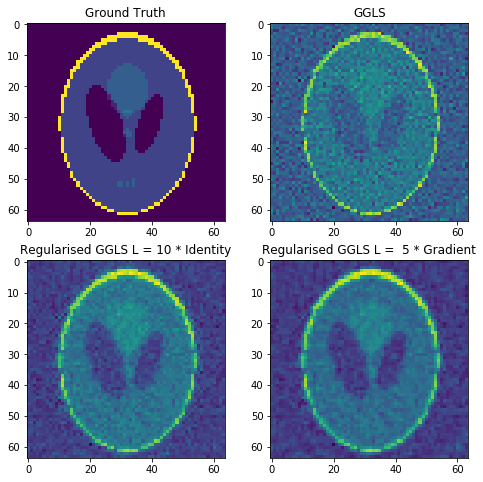

In [10]:
# Show results
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.imshow(data1.as_array())
plt.title('Ground Truth')

plt.subplot(2,2,2)
plt.imshow(cgls1.get_output().as_array())
plt.title('GGLS')

plt.subplot(2,2,3)
plt.imshow(cgls2.get_output().as_array())
plt.title('Regularised GGLS L = {} * Identity'.format(alpha1))

plt.subplot(2,2,4)
plt.imshow(cgls3.get_output().as_array())
plt.title('Regularised GGLS L =  {} * Gradient'.format(alpha2))

plt.show()

In [11]:
CGLS??


<center> Compare our regularised solution ( L = Gradient ) with CVXPY </center>

In [12]:
from ccpi.optimisation.operators import SparseFiniteDiff
import astra

    
##Construct problem    
u = Variable(N*N)

# Define 
DY = SparseFiniteDiff(ig1, direction=0, bnd_cond='Neumann')
DX = SparseFiniteDiff(ig1, direction=1, bnd_cond='Neumann')

regulariser = alpha2**2 * sum_squares(norm(vstack([DX.matrix() * vec(u), DY.matrix() * vec(u)]), 2, axis = 0))

# create matrix representation for Astra operator

vol_geom = astra.create_vol_geom(N, N)
proj_geom = astra.create_proj_geom('parallel', 1.0, detectors, angles)

proj_id = astra.create_projector('line', proj_geom, vol_geom)

matrix_id = astra.projector.matrix(proj_id)

ProjMat = astra.matrix.get(matrix_id)

fidelity = sum_squares( ProjMat * u - noisy_data.as_array().ravel()) 

solver = MOSEK
obj =  Minimize( regulariser +  fidelity)
prob = Problem(obj)
result = prob.solve(verbose = True, solver = solver)    



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 22788           
  Cones                  : 4098            
  Scalar variables       : 30982           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 22788           
  Cones                  : 4098            
  Scalar variables       : 30982           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 18561
Optimizer  - Cones                  : 4098
Optimizer  - Scalar vari

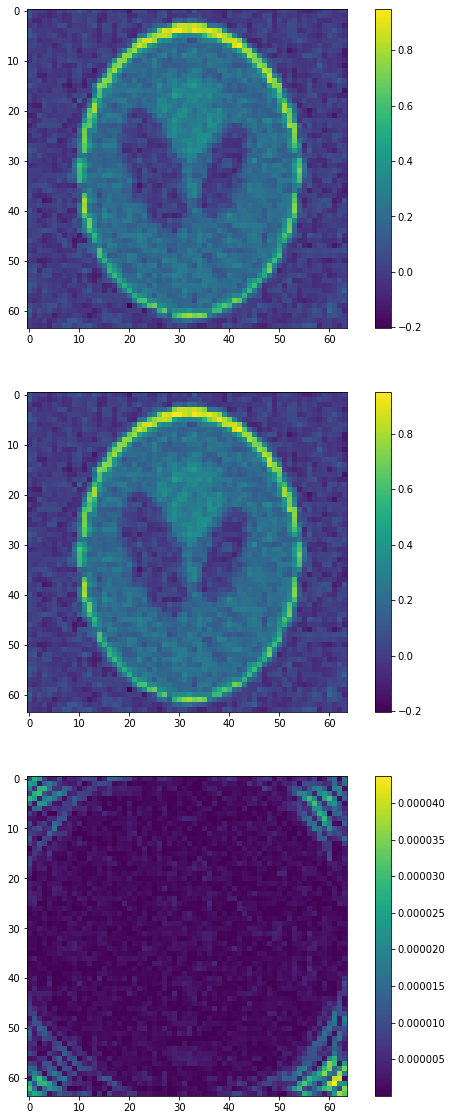

Primal Objective (CVX) 7890.880679014327 
Primal Objective (CGLS) 7890.880828311683 


In [13]:
plt.figure(figsize=(10,20))

plt.subplot(3,1,1)
plt.imshow(np.reshape(u.value, (N, N)))    
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(cgls3.get_output().as_array())    
plt.colorbar()

plt.subplot(3,1,3)
plt.imshow(np.abs(cgls3.get_output().as_array() - np.reshape(u.value, (N, N)) ))    
plt.colorbar()

plt.show()

print('Primal Objective (CVX) {} '.format(obj.value))
print('Primal Objective (CGLS) {} '.format(cgls3.objective[-1]))
